# Amazon Product Reviews: NLP Analysis System
## Named Entity Recognition (NER) & Sentiment Analysis with spaCy

## Project Overview
This notebook implements a comprehensive NLP analysis system for Amazon product reviews using spaCy. We perform:
- **Named Entity Recognition (NER)**: Extract products, brands, organizations, and locations
- **Rule-Based Sentiment Analysis**: Classify reviews as Positive/Negative/Neutral
- **Entity-Sentiment Correlation**: Analyze relationships between mentioned entities and sentiment

**Dataset**: Amazon product reviews from train.ft.txt.bz2
**Tools**: spaCy, pandas, matplotlib, seaborn, wordcloud

## 1. Setup and Library Imports

Import all required libraries for NLP analysis, data processing, and visualization.

In [12]:
# Import required libraries
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import bz2
import re
from collections import Counter, defaultdict
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
from wordcloud import WordCloud

# Set random seeds for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directories
os.makedirs('outputs', exist_ok=True)

print(" Libraries imported successfully!")
print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

 Libraries imported successfully!
Current time: 2025-10-27 12:48:41


In [13]:
# Load spaCy English model
print("Loading spaCy model...")
try:
    # Try loading the medium model for better accuracy
    nlp = spacy.load("en_core_web_md")
    print("Loaded en_core_web_md (medium model)")
except OSError:
    try:
        # Fall back to small model
        nlp = spacy.load("en_core_web_sm")
        print("Loaded en_core_web_sm (small model)")
    except OSError:
        print(" Model not found. Downloading en_core_web_sm...")
        import subprocess
        subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
        nlp = spacy.load("en_core_web_sm")
        print(" Downloaded and loaded en_core_web_sm")

# Display model information
print(f"\nModel Info:")
print(f"  Pipeline components: {nlp.pipe_names}")
print(f"  Entity types available: {len(nlp.get_pipe('ner').labels)} types")

Loading spaCy model...
Loaded en_core_web_sm (small model)

Model Info:
  Pipeline components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
  Entity types available: 18 types
Loaded en_core_web_sm (small model)

Model Info:
  Pipeline components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
  Entity types available: 18 types


## 2. Load Amazon Reviews Dataset

Amazon reviews are stored in FastText format (.ft.txt.bz2):
- Format: `__label__N review_text` where N is the rating (1-5)
- We'll extract ratings and review text
- Load a manageable subset for analysis

In [14]:
# Load Amazon reviews from .bz2 file
print(f"Loading reviews from: train.ft.txt.bz2")
start_time = time.time()

reviews = []
ratings = []
max_reviews = 5000

with bz2.open('train.ft.txt.bz2', 'rt', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= max_reviews:
            break
            
        # Parse FastText format: __label__N review_text
        match = re.match(r'__label__(\d+)\s+(.*)', line.strip())
        if match:
            rating = int(match.group(1))
            review = match.group(2)
            
            # Basic cleaning
            review = re.sub(r'\s+', ' ', review).strip()
            
            if len(review) > 20:  # Filter very short reviews
                ratings.append(rating)
                reviews.append(review)
        
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i + 1} lines...", end='\r')

# Create DataFrame
df_reviews = pd.DataFrame({
    'rating': ratings,
    'review_text': reviews
})

elapsed = time.time() - start_time
print(f"\n✓ Loaded {len(df_reviews):,} reviews in {elapsed:.2f} seconds")

Loading reviews from: train.ft.txt.bz2
  Processed 5000 lines...
✓ Loaded 5,000 reviews in 1.18 seconds
  Processed 5000 lines...
✓ Loaded 5,000 reviews in 1.18 seconds


## 3. Data Exploration

Let's examine the loaded reviews and understand the data distribution.

In [15]:
# Display dataset info
print("Dataset Overview:")
print(f"  Total reviews: {len(df_reviews):,}")
print(f"  Columns: {list(df_reviews.columns)}")
print(f"\nDataset Info:")
print(df_reviews.info())

print("\n" + "="*80)
print("Rating Distribution:")
print("="*80)
rating_dist = df_reviews['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    percentage = (count / len(df_reviews)) * 100
    bar = '█' * int(percentage / 2)
    print(f"  {'⭐' * rating} ({rating}): {count:>5,} ({percentage:>5.1f}%) {bar}")

print("\n" + "="*80)
print("Review Length Statistics:")
print("="*80)
df_reviews['review_length'] = df_reviews['review_text'].str.len()
print(df_reviews['review_length'].describe())

print("\n" + "="*80)
print("Sample Reviews:")
print("="*80)
for idx in df_reviews.sample(5).index:
    print(f"\n[Rating: {'⭐' * df_reviews.loc[idx, 'rating']}]")
    print(f"Review: {df_reviews.loc[idx, 'review_text'][:200]}...")
    print("-" * 80)

Dataset Overview:
  Total reviews: 5,000
  Columns: ['rating', 'review_text']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rating       5000 non-null   int64 
 1   review_text  5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 78.3+ KB
None

Rating Distribution:
  ⭐ (1): 2,692 ( 53.8%) ██████████████████████████
  ⭐⭐ (2): 2,308 ( 46.2%) ███████████████████████

Review Length Statistics:
count    5000.000000
mean      434.491200
std       236.217292
min       101.000000
25%       237.000000
50%       388.000000
75%       597.000000
max      1014.000000
Name: review_length, dtype: float64

Sample Reviews:

[Rating: ⭐]
Review: Tomb Stinker - Eidos' Revenge: Cutting edge technology does not a great game make. This game is proof.The graphics are beautiful, which accounts for the extra star for the overall rating. If

Saved: outputs/rating_distribution.png


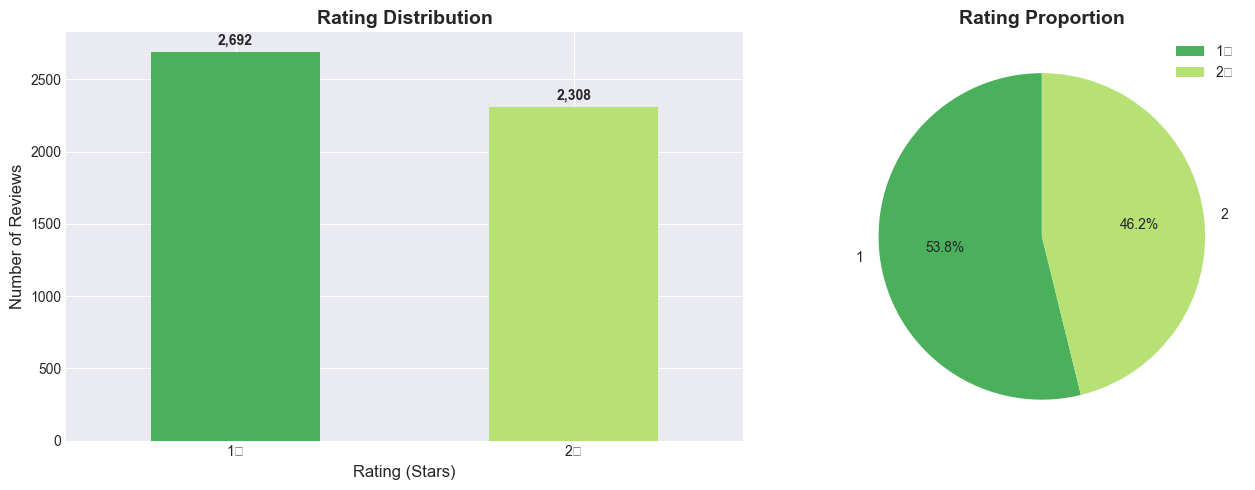

In [16]:
# Visualize rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
rating_dist.plot(kind='bar', ax=ax1, color=sns.color_palette("RdYlGn", 5)[::-1])
ax1.set_title('Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rating (Stars)', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.set_xticklabels([f"{i}⭐" for i in rating_dist.index], rotation=0)
for i, v in enumerate(rating_dist.values):
    ax1.text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
ax2 = axes[1]
rating_dist.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90,
                 colors=sns.color_palette("RdYlGn", 5)[::-1])
ax2.set_title('Rating Proportion', fontsize=14, fontweight='bold')
ax2.set_ylabel('')
ax2.legend([f"{i}⭐" for i in rating_dist.index], loc='best')

plt.tight_layout()
plt.savefig('outputs/rating_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: outputs/rating_distribution.png")
plt.show()

## 4. Named Entity Recognition (NER)

Extract entities from reviews using spaCy's NER pipeline:
- **PRODUCT**: Product names (captured as various entity types)
- **ORG**: Organizations and brands
- **GPE**: Geographical locations
- **PERSON**: People mentioned
- **MONEY, QUANTITY, CARDINAL**: Product details

In [17]:
# Extract entities from reviews using spaCy
print("Extracting entities from reviews...")
start_time = time.time()

entity_results = []
batch_size = 50

for i in range(0, len(df_reviews), batch_size):
    batch = df_reviews.iloc[i:i+batch_size]
    
    # Process batch with spaCy
    docs = list(nlp.pipe(batch['review_text'].astype(str), batch_size=batch_size))
    
    for idx, doc in enumerate(docs):
        review_idx = i + idx
        
        # Extract entities from this review
        for ent in doc.ents:
            entity_results.append({
                'review_id': review_idx,
                'rating': df_reviews.iloc[review_idx]['rating'],
                'entity_text': ent.text,
                'entity_label': ent.label_,
                'entity_description': spacy.explain(ent.label_)
            })
    
    if (i + batch_size) % 500 == 0:
        print(f"  Processed {min(i + batch_size, len(df_reviews)):,}/{len(df_reviews):,} reviews...", end='\r')

elapsed = time.time() - start_time
print(f"\n Entity extraction complete in {elapsed:.2f} seconds")
print(f"  Found {len(entity_results):,} entity mentions")

# Create entities DataFrame
df_entities = pd.DataFrame(entity_results)
print(f" Created entities DataFrame with {len(df_entities):,} rows")

Extracting entities from reviews...
  Processed 5,000/5,000 reviews...
✓ Entity extraction complete in 342.43 seconds
  Found 17,314 entity mentions
 Created entities DataFrame with 17,314 rows
  Processed 5,000/5,000 reviews...
✓ Entity extraction complete in 342.43 seconds
  Found 17,314 entity mentions
 Created entities DataFrame with 17,314 rows


## 5. Entity Analysis Results

Display and visualize the extracted entities.

In [18]:
# Display entity extraction results

if len(df_entities) > 0:
    print(f"\nTotal unique entities: {df_entities['entity_text'].nunique():,}")
    print(f"Total entity mentions: {len(df_entities):,}")
    
    
    print("Entity Types Distribution:")
 
    entity_type_dist = df_entities['entity_label'].value_counts()
    for ent_type, count in entity_type_dist.head(10).items():
        percentage = (count / len(df_entities)) * 100
        bar = '█' * int(percentage / 2)
        description = spacy.explain(ent_type) or "Unknown"
        print(f"  {ent_type:15s} ({description[:30]:30s}): {count:>6,} ({percentage:>5.1f}%) {bar}")
   
    print("Top 20 Most Mentioned Entities:")
   
    top_entities = df_entities.groupby(['entity_text', 'entity_label']).size().reset_index(name='count')
    top_entities = top_entities.sort_values('count', ascending=False).head(20)
    
    for idx, row in top_entities.iterrows():
        print(f"  {row['entity_text']:30s} | {row['entity_label']:10s} | {row['count']:>5,} mentions")
    
   
    print("Sample Entities by Type:")
    for ent_type in ['ORG', 'PRODUCT', 'GPE', 'PERSON', 'MONEY']:
        if ent_type in df_entities['entity_label'].unique():
            samples = df_entities[df_entities['entity_label'] == ent_type]['entity_text'].value_counts().head(5)
            print(f"\n{ent_type} ({spacy.explain(ent_type) or 'Unknown'}):")
            for entity, count in samples.items():
                print(f"  - {entity} ({count} mentions)")
else:
    print(" No entities found in the reviews")


Total unique entities: 7,941
Total entity mentions: 17,314
Entity Types Distribution:
  PERSON          (People, including fictional   ):  3,999 ( 23.1%) ███████████
  ORG             (Companies, agencies, instituti):  3,317 ( 19.2%) █████████
  CARDINAL        (Numerals that do not fall unde):  2,836 ( 16.4%) ████████
  DATE            (Absolute or relative dates or ):  2,228 ( 12.9%) ██████
  ORDINAL         ("first", "second", etc.       ):  1,012 (  5.8%) ██
  GPE             (Countries, cities, states     ):    972 (  5.6%) ██
  NORP            (Nationalities or religious or ):    737 (  4.3%) ██
  WORK_OF_ART     (Titles of books, songs, etc.  ):    570 (  3.3%) █
  TIME            (Times smaller than a day      ):    480 (  2.8%) █
  MONEY           (Monetary values, including uni):    270 (  1.6%) 
Top 20 Most Mentioned Entities:
  first                          | ORDINAL    |   621 mentions
  one                            | CARDINAL   |   495 mentions
  two                  

 Saved: outputs/entity_analysis.png


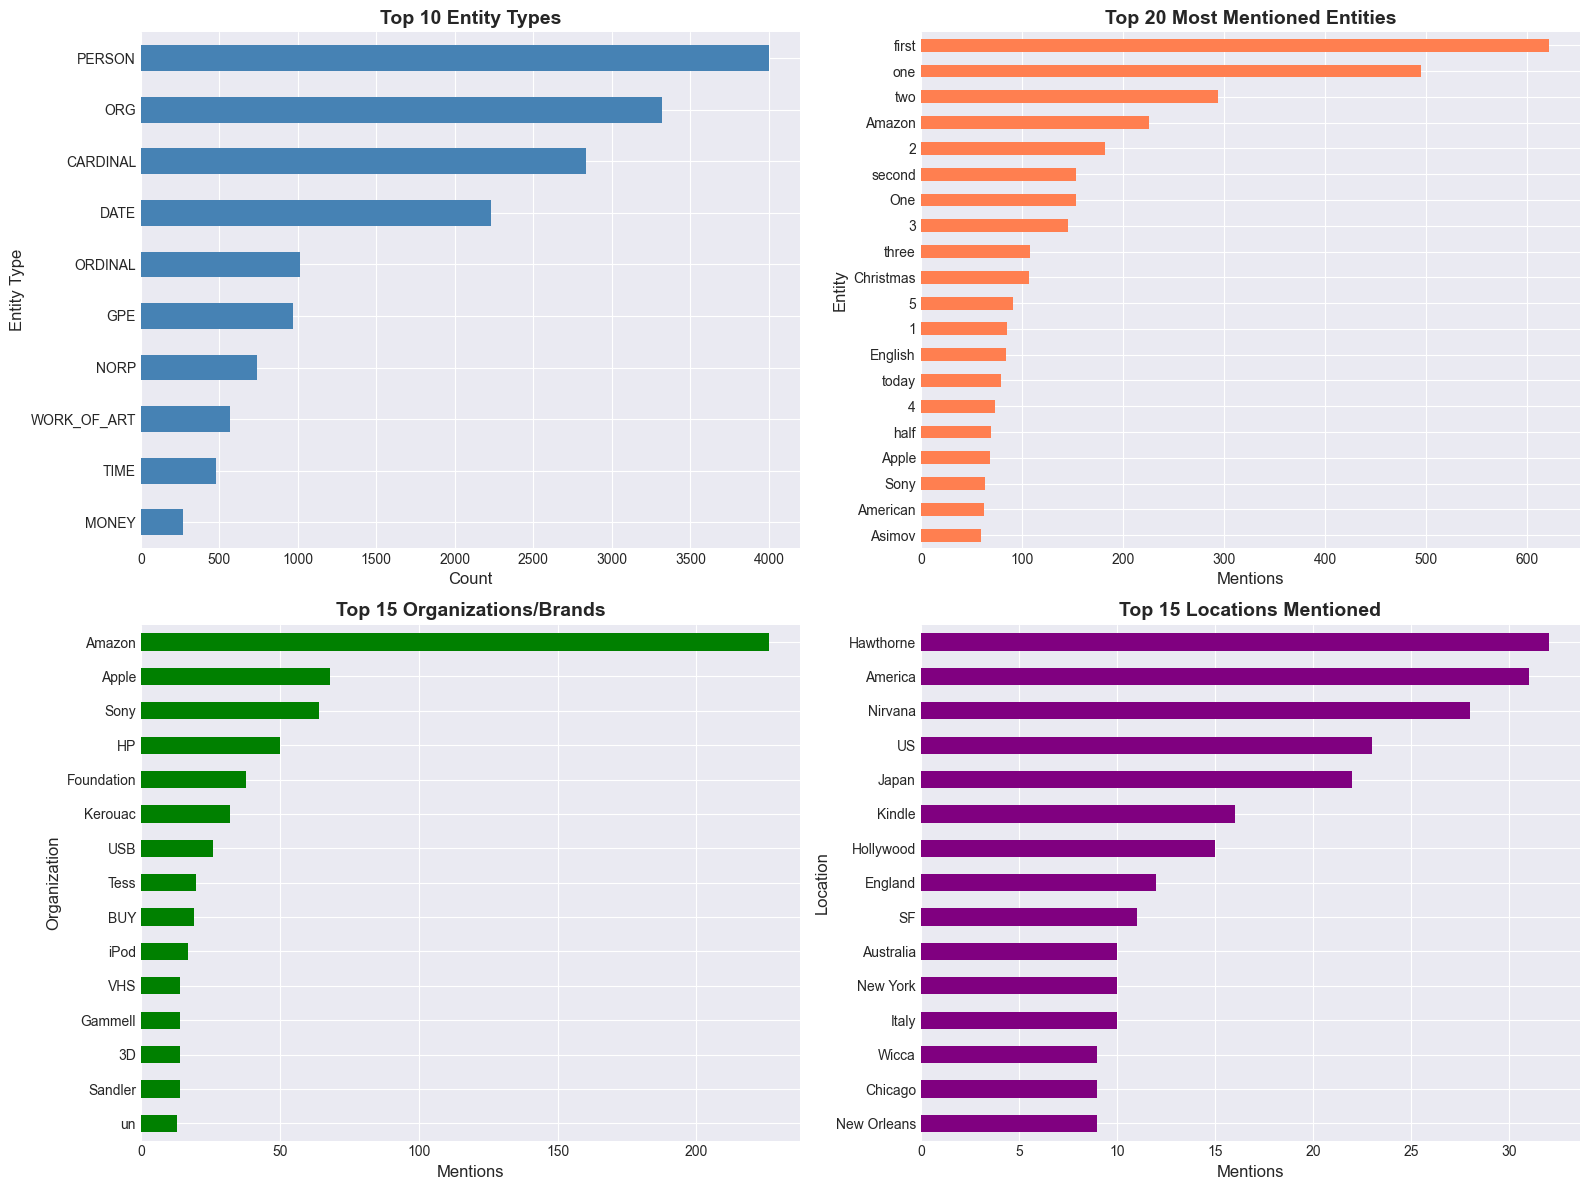

In [19]:
# Visualize entity distribution
if len(df_entities) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Entity type distribution
    ax1 = axes[0, 0]
    entity_type_counts = df_entities['entity_label'].value_counts().head(10)
    entity_type_counts.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_title('Top 10 Entity Types', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Count', fontsize=12)
    ax1.set_ylabel('Entity Type', fontsize=12)
    ax1.invert_yaxis()
    
    # Plot 2: Top entities
    ax2 = axes[0, 1]
    top_20_entities = df_entities['entity_text'].value_counts().head(20)
    top_20_entities.plot(kind='barh', ax=ax2, color='coral')
    ax2.set_title('Top 20 Most Mentioned Entities', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Mentions', fontsize=12)
    ax2.set_ylabel('Entity', fontsize=12)
    ax2.invert_yaxis()
    
    # Plot 3: Organizations (ORG)
    ax3 = axes[1, 0]
    if 'ORG' in df_entities['entity_label'].values:
        org_entities = df_entities[df_entities['entity_label'] == 'ORG']['entity_text'].value_counts().head(15)
        org_entities.plot(kind='barh', ax=ax3, color='green')
        ax3.set_title('Top 15 Organizations/Brands', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Mentions', fontsize=12)
        ax3.set_ylabel('Organization', fontsize=12)
        ax3.invert_yaxis()
    else:
        ax3.text(0.5, 0.5, 'No ORG entities found', ha='center', va='center', fontsize=12)
        ax3.axis('off')
    
    # Plot 4: Locations (GPE)
    ax4 = axes[1, 1]
    if 'GPE' in df_entities['entity_label'].values:
        gpe_entities = df_entities[df_entities['entity_label'] == 'GPE']['entity_text'].value_counts().head(15)
        gpe_entities.plot(kind='barh', ax=ax4, color='purple')
        ax4.set_title('Top 15 Locations Mentioned', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Mentions', fontsize=12)
        ax4.set_ylabel('Location', fontsize=12)
        ax4.invert_yaxis()
    else:
        ax4.text(0.5, 0.5, 'No GPE entities found', ha='center', va='center', fontsize=12)
        ax4.axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/entity_analysis.png', dpi=300, bbox_inches='tight')
    print(" Saved: outputs/entity_analysis.png")
    plt.show()
else:
    print(" No entities to visualize")

## 6. Rule-Based Sentiment Analysis

Implement custom rule-based sentiment analysis using:
1. **Positive/Negative keyword lists**
2. **spaCy linguistic features** (adjectives, adverbs)
3. **Negation handling** (not, never, no, etc.)
4. **Intensity modifiers** (very, extremely, slightly)

In [21]:
# Define sentiment lexicons
POSITIVE_WORDS = {
    'good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 'perfect', 
    'love', 'loved', 'best', 'awesome', 'beautiful', 'happy', 'satisfied', 'recommend',
    'quality', 'comfortable', 'easy', 'fast', 'useful', 'helpful', 'nice', 'pleased',
    'impressed', 'outstanding', 'superior', 'exceptional', 'brilliant', 'superb',
    'delighted', 'enjoyed', 'worth', 'favorite', 'reliable', 'sturdy', 'durable'
}

NEGATIVE_WORDS = {
    'bad', 'terrible', 'horrible', 'awful', 'poor', 'worst', 'hate', 'hated',
    'disappointing', 'disappointed', 'useless', 'waste', 'defective', 'broken',
    'cheap', 'junk', 'garbage', 'difficult', 'hard', 'uncomfortable', 'slow',
    'weak', 'fail', 'failed', 'problem', 'issue', 'wrong', 'not', 'never',
    'unhappy', 'unsatisfied', 'annoying', 'frustrating', 'overpriced', 'expensive'
}

NEGATION_WORDS = {'not', 'no', 'never', 'neither', 'nor', 'none', 'nobody', 'nothing', "n't", 'cannot', 'cant'}

INTENSIFIERS = {
    'very': 1.5, 'extremely': 2.0, 'absolutely': 2.0, 'completely': 1.8,
    'totally': 1.8, 'highly': 1.5, 'really': 1.3, 'quite': 1.2,
    'slightly': 0.5, 'somewhat': 0.7, 'fairly': 0.8, 'barely': 0.3
}

print("✓ Sentiment lexicons loaded")
print(f"  Positive words: {len(POSITIVE_WORDS)}")
print(f"  Negative words: {len(NEGATIVE_WORDS)}")
print(f"  Negation words: {len(NEGATION_WORDS)}")
print(f"  Intensifiers: {len(INTENSIFIERS)}")

✓ Sentiment lexicons loaded
  Positive words: 36
  Negative words: 35
  Negation words: 11
  Intensifiers: 12


In [22]:
# Perform rule-based sentiment analysis
print("Performing sentiment analysis on reviews...")
start_time = time.time()

sentiment_scores = []
sentiment_labels = []
positive_counts = []
negative_counts = []

for idx, review_text in enumerate(df_reviews['review_text']):
    # Process text with spaCy
    doc = nlp(review_text.lower())
    
    positive_score = 0
    negative_score = 0
    
    # Analyze each word
    for i, token in enumerate(doc):
        # Skip punctuation and stop words (except negations)
        if token.is_punct or (token.is_stop and token.text not in NEGATION_WORDS):
            continue
        
        word = token.text
        lemma = token.lemma_
        
        # Check for intensifier in previous word
        intensifier = 1.0
        if i > 0 and doc[i-1].text in INTENSIFIERS:
            intensifier = INTENSIFIERS[doc[i-1].text]
        
        # Check for negation in previous 2 words
        negated = False
        for j in range(max(0, i-2), i):
            if doc[j].text in NEGATION_WORDS or doc[j].text.endswith("n't"):
                negated = True
                break
        
        # Score positive words
        if word in POSITIVE_WORDS or lemma in POSITIVE_WORDS:
            score = 1.0 * intensifier
            if negated:
                negative_score += score
            else:
                positive_score += score
        
        # Score negative words
        elif word in NEGATIVE_WORDS or lemma in NEGATIVE_WORDS:
            score = 1.0 * intensifier
            if negated:
                positive_score += score
            else:
                negative_score += score
        
        # Use adjectives for mild sentiment
        elif token.pos_ in ['ADJ', 'ADV']:
            if not negated:
                positive_score += 0.3 * intensifier
    
    # Calculate sentiment score (-1 to 1)
    total = positive_score + negative_score
    if total > 0:
        sentiment_score = (positive_score - negative_score) / total
    else:
        sentiment_score = 0.0
    
    # Classify sentiment
    if sentiment_score > 0.2:
        sentiment_label = 'Positive'
    elif sentiment_score < -0.2:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    sentiment_scores.append(sentiment_score)
    sentiment_labels.append(sentiment_label)
    positive_counts.append(int(positive_score))
    negative_counts.append(int(negative_score))
    
    if (idx + 1) % 500 == 0:
        print(f"  Analyzed {idx + 1:,}/{len(df_reviews):,} reviews...", end='\r')

# Add results to dataframe
df_reviews['sentiment_score'] = sentiment_scores
df_reviews['sentiment_label'] = sentiment_labels
df_reviews['positive_count'] = positive_counts
df_reviews['negative_count'] = negative_counts

elapsed = time.time() - start_time
print(f"\nSentiment analysis complete in {elapsed:.2f} seconds")
print(f"  Average: {elapsed/len(df_reviews)*1000:.2f} ms per review")

Performing sentiment analysis on reviews...
  Analyzed 5,000/5,000 reviews...
Sentiment analysis complete in 166.17 seconds
  Average: 33.23 ms per review
  Analyzed 5,000/5,000 reviews...
Sentiment analysis complete in 166.17 seconds
  Average: 33.23 ms per review


In [ ]:
# Display sentiment analysis results
print("="*80)
print("SENTIMENT ANALYSIS SUMMARY")
print("="*80)

print("\nSentiment Distribution:")
sentiment_dist = df_reviews['sentiment_label'].value_counts()
for sentiment, count in sentiment_dist.items():
    percentage = (count / len(df_reviews)) * 100
    bar = '█' * int(percentage / 2)
    emoji = '😊' if sentiment == 'Positive' else ('😐' if sentiment == 'Neutral' else '😞')
    print(f"  {emoji} {sentiment:10s}: {count:>5,} ({percentage:>5.1f}%) {bar}")

print("\n" + "="*80)
print("Sentiment Score Statistics:")
print("="*80)
print(df_reviews['sentiment_score'].describe())

print("\n" + "="*80)
print("Correlation: Rating vs Sentiment Score")
print("="*80)
correlation = df_reviews[['rating', 'sentiment_score']].corr().iloc[0, 1]
print(f"  Pearson correlation: {correlation:.4f}")

print("\n" + "="*80)
print("Average Sentiment by Rating:")
print("="*80)
sentiment_by_rating = df_reviews.groupby('rating')['sentiment_score'].mean()
for rating, avg_sentiment in sentiment_by_rating.items():
    print(f"  {'⭐' * rating} ({rating}): {avg_sentiment:>6.3f}")

print("\n" + "="*80)
print("Sample Reviews by Sentiment:")
print("="*80)

for sentiment in ['Positive', 'Negative', 'Neutral']:
    print(f"\n{sentiment.upper()} Examples:")
    sample = df_reviews[df_reviews['sentiment_label'] == sentiment].sample(min(2, len(df_reviews[df_reviews['sentiment_label'] == sentiment])))
    for idx, row in sample.iterrows():
        print(f"\n  [Rating: {'⭐' * row['rating']} | Score: {row['sentiment_score']:.3f}]")
        print(f"  Review: {row['review_text'][:150]}...")
        print(f"  (Positive words: {row['positive_count']}, Negative words: {row['negative_count']})")
    print("-" * 80)

SENTIMENT ANALYSIS SUMMARY

Sentiment Distribution:
  😊 Positive  : 2,692 ( 53.8%) ██████████████████████████
  😞 Negative  : 1,235 ( 24.7%) ████████████
  😐 Neutral   : 1,073 ( 21.5%) ██████████

Sentiment Score Statistics:
count    5000.000000
mean        0.259156
std         0.571456
min        -1.000000
25%        -0.194030
50%         0.272727
75%         0.777778
max         1.000000
Name: sentiment_score, dtype: float64

Correlation: Rating vs Sentiment Score
  Pearson correlation: 0.5800

Average Sentiment by Rating:
  ⭐ (1): -0.048
  ⭐⭐ (2):  0.617

Sample Reviews by Sentiment:

POSITIVE Examples:

  [Rating: ⭐ | Score: 0.459]
  Review: a real pain: I bought this item 2 months ago because it was small and cheap. I use it daily. The grinding mechanism is already tired. Now it takes a l...
  (Positive words: 2, Negative words: 1)

  [Rating: ⭐ | Score: 0.355]
  Review: On the Road Again.: Ok. Let's talk like ordinary people. If you are someone who has to buy a new TV unless you 

✓ Saved: outputs/sentiment_analysis.png


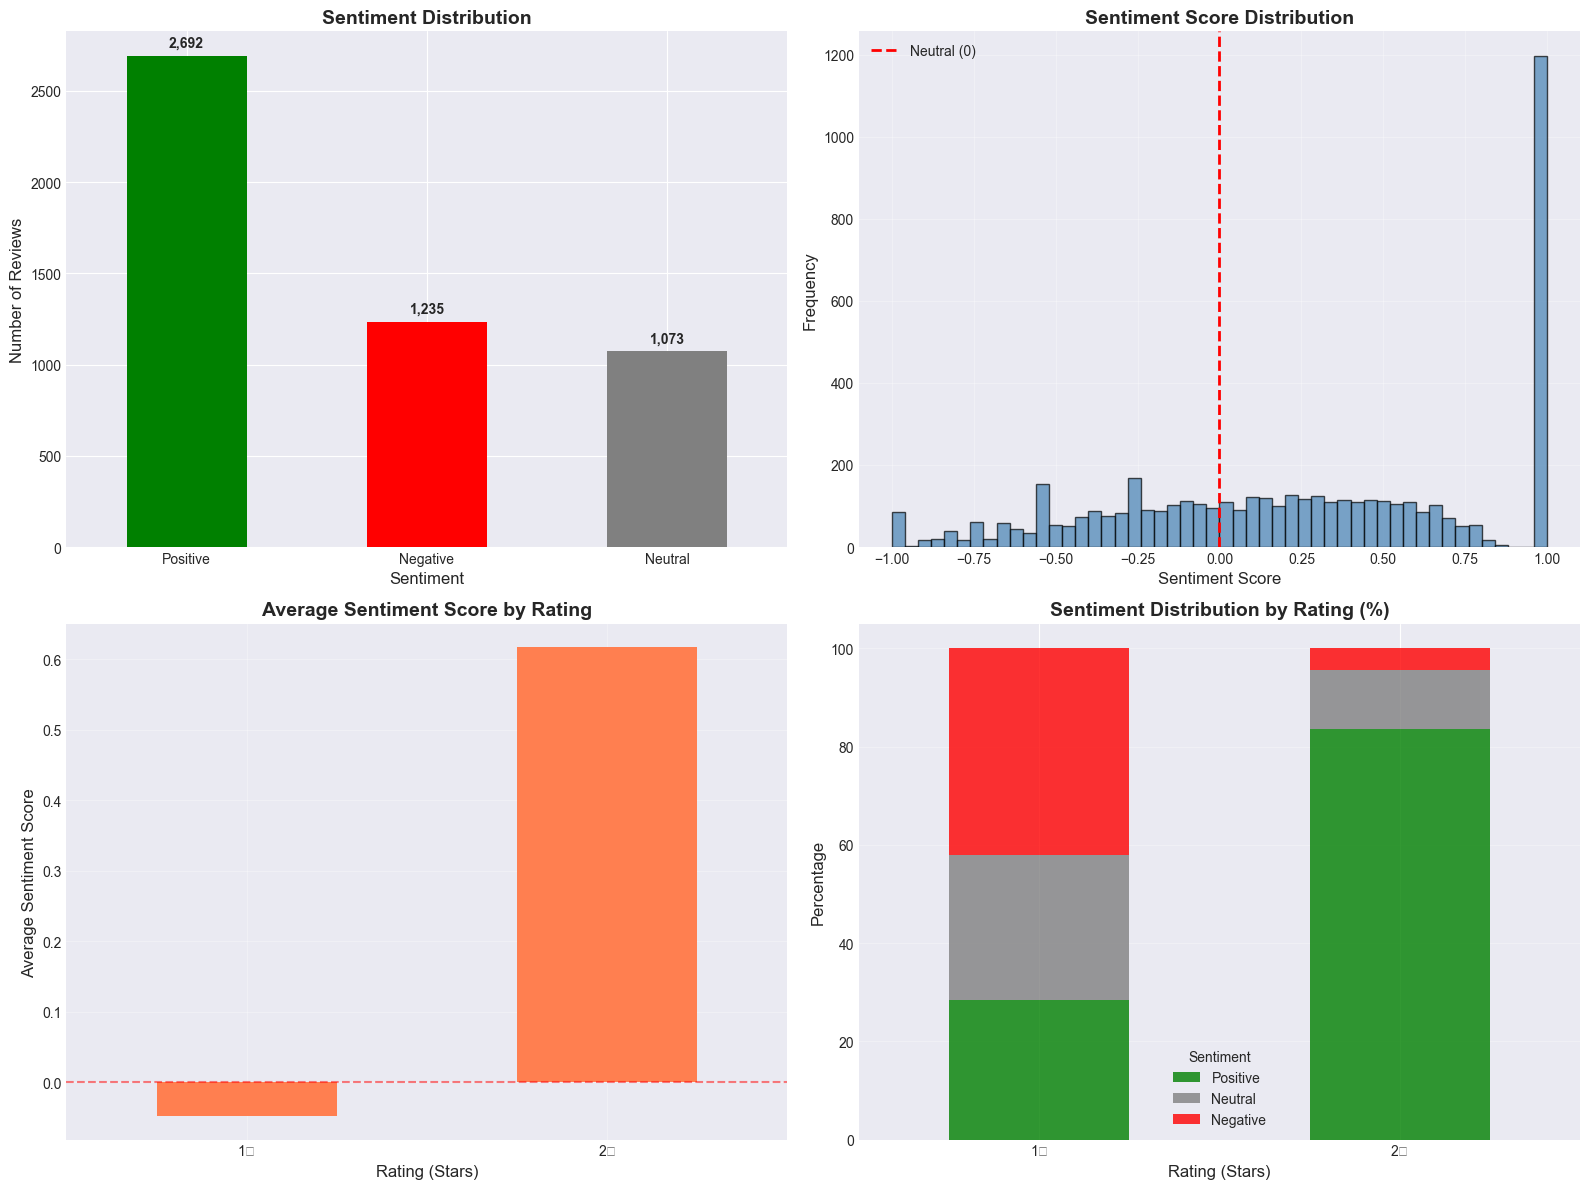

In [25]:
# Visualize sentiment analysis results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Sentiment distribution
ax1 = axes[0, 0]
sentiment_counts = df_reviews['sentiment_label'].value_counts()
colors_sentiment = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
sentiment_colors = [colors_sentiment.get(x, 'blue') for x in sentiment_counts.index]
sentiment_counts.plot(kind='bar', ax=ax1, color=sentiment_colors)
ax1.set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.set_xticklabels(sentiment_counts.index, rotation=0)
for i, v in enumerate(sentiment_counts.values):
    ax1.text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Plot 2: Sentiment score distribution
ax2 = axes[0, 1]
ax2.hist(df_reviews['sentiment_score'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
ax2.set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentiment Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Rating vs Sentiment
ax3 = axes[1, 0]
rating_sentiment = df_reviews.groupby('rating')['sentiment_score'].mean()
rating_sentiment.plot(kind='bar', ax=ax3, color='coral')
ax3.set_title('Average Sentiment Score by Rating', fontsize=14, fontweight='bold')
ax3.set_xlabel('Rating (Stars)', fontsize=12)
ax3.set_ylabel('Average Sentiment Score', fontsize=12)
ax3.set_xticklabels([f"{i}⭐" for i in rating_sentiment.index], rotation=0)
ax3.axhline(0, color='red', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

# Plot 4: Sentiment by Rating (stacked)
ax4 = axes[1, 1]
sentiment_rating_crosstab = pd.crosstab(df_reviews['rating'], df_reviews['sentiment_label'], normalize='index') * 100
sentiment_rating_crosstab[['Positive', 'Neutral', 'Negative']].plot(
    kind='bar', stacked=True, ax=ax4, 
    color=['green', 'gray', 'red'], alpha=0.8
)
ax4.set_title('Sentiment Distribution by Rating (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Rating (Stars)', fontsize=12)
ax4.set_ylabel('Percentage', fontsize=12)
ax4.set_xticklabels([f"{i}⭐" for i in sentiment_rating_crosstab.index], rotation=0)
ax4.legend(title='Sentiment', loc='best')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/sentiment_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: outputs/sentiment_analysis.png")
plt.show()

## 7. Entity-Sentiment Correlation Analysis

Analyze the relationship between mentioned entities and sentiment to identify:
- Which brands/products get positive vs negative reviews
- Location-based sentiment patterns
- Entity mentions in different sentiment categories

In [26]:
# Merge entity and sentiment data
if len(df_entities) > 0:
    df_entity_sentiment = df_entities.merge(
        df_reviews[['sentiment_label', 'sentiment_score', 'rating']],
        left_on='review_id',
        right_index=True,
        how='left'
    )
    
    print("="*80)
    print("ENTITY-SENTIMENT CORRELATION ANALYSIS")
    print("="*80)
    
    # Top entities by sentiment
    print("\n" + "="*80)
    print("Top Entities in Positive Reviews:")
    print("="*80)
    positive_entities = df_entity_sentiment[df_entity_sentiment['sentiment_label'] == 'Positive']['entity_text'].value_counts().head(15)
    for entity, count in positive_entities.items():
        print(f"  {entity:30s}: {count:>5,} mentions")
    
    print("\n" + "="*80)
    print("Top Entities in Negative Reviews:")
    print("="*80)
    negative_entities = df_entity_sentiment[df_entity_sentiment['sentiment_label'] == 'Negative']['entity_text'].value_counts().head(15)
    for entity, count in negative_entities.items():
        print(f"  {entity:30s}: {count:>5,} mentions")
    
    # Average sentiment per entity (for frequently mentioned entities)
    print("\n" + "="*80)
    print("Average Sentiment for Frequently Mentioned Entities:")
    print("="*80)
    entity_sentiment_avg = df_entity_sentiment.groupby('entity_text').agg({
        'sentiment_score': 'mean',
        'entity_text': 'count'
    }).rename(columns={'entity_text': 'count'})
    
    # Filter entities mentioned at least 10 times
    entity_sentiment_avg = entity_sentiment_avg[entity_sentiment_avg['count'] >= 10].sort_values('sentiment_score')
    
    print("\nMost Negative Entities (mentioned 10+ times):")
    for entity, row in entity_sentiment_avg.head(10).iterrows():
        print(f"  {entity:30s}: {row['sentiment_score']:>6.3f} ({int(row['count']):>3} mentions)")
    
    print("\nMost Positive Entities (mentioned 10+ times):")
    for entity, row in entity_sentiment_avg.tail(10).iterrows():
        print(f"  {entity:30s}: {row['sentiment_score']:>6.3f} ({int(row['count']):>3} mentions)")
    
    print(f"\n✓ Entity-sentiment correlation analysis complete")
else:
    print("⚠ No entities found for correlation analysis")
    df_entity_sentiment = pd.DataFrame()

ENTITY-SENTIMENT CORRELATION ANALYSIS

Top Entities in Positive Reviews:
  first                         :   325 mentions
  one                           :   264 mentions
  two                           :   166 mentions
  One                           :   103 mentions
  2                             :   101 mentions
  second                        :    93 mentions
  3                             :    86 mentions
  Amazon                        :    81 mentions
  Christmas                     :    65 mentions
  today                         :    55 mentions
  5                             :    55 mentions
  three                         :    52 mentions
  American                      :    49 mentions
  4                             :    45 mentions
  English                       :    44 mentions

Top Entities in Negative Reviews:
  first                         :   121 mentions
  one                           :    98 mentions
  Amazon                        :    89 mentions
  two     

## 8. Word Cloud Visualizations

Generate word clouds to visualize the most common words in positive and negative reviews.

Generating word clouds...
✓ Saved: outputs/wordclouds.png
✓ Saved: outputs/wordclouds.png


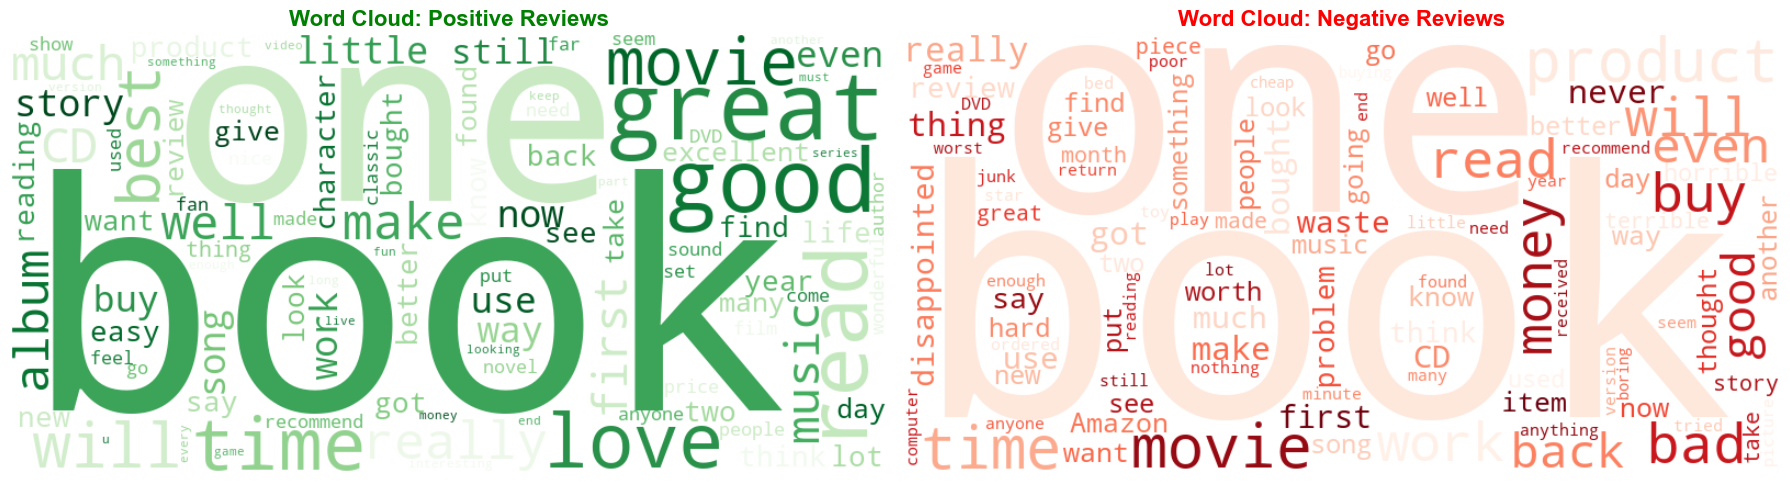

In [27]:
# Generate word clouds for positive and negative reviews
print("Generating word clouds...")

# Combine reviews by sentiment
positive_text = ' '.join(df_reviews[df_reviews['sentiment_label'] == 'Positive']['review_text'].values)
negative_text = ' '.join(df_reviews[df_reviews['sentiment_label'] == 'Negative']['review_text'].values)

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Positive word cloud
ax1 = axes[0]
if len(positive_text) > 0:
    wordcloud_pos = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Greens',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(positive_text)
    
    ax1.imshow(wordcloud_pos, interpolation='bilinear')
    ax1.set_title('Word Cloud: Positive Reviews', fontsize=16, fontweight='bold', color='green')
    ax1.axis('off')
else:
    ax1.text(0.5, 0.5, 'No positive reviews', ha='center', va='center', fontsize=14)
    ax1.axis('off')

# Negative word cloud
ax2 = axes[1]
if len(negative_text) > 0:
    wordcloud_neg = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Reds',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(negative_text)
    
    ax2.imshow(wordcloud_neg, interpolation='bilinear')
    ax2.set_title('Word Cloud: Negative Reviews', fontsize=16, fontweight='bold', color='red')
    ax2.axis('off')
else:
    ax2.text(0.5, 0.5, 'No negative reviews', ha='center', va='center', fontsize=14)
    ax2.axis('off')

plt.tight_layout()
plt.savefig('outputs/wordclouds.png', dpi=300, bbox_inches='tight')
print("✓ Saved: outputs/wordclouds.png")
plt.show()

## 9. Export Results to CSV

Save all analysis results to CSV files for further analysis and reporting.

In [28]:
# Prepare final results DataFrame with entities
print("Preparing final results...")

# Group entities by review_id
if len(df_entities) > 0:
    entities_grouped = df_entities.groupby('review_id').agg({
        'entity_text': lambda x: ' | '.join(x.unique()),
        'entity_label': lambda x: ' | '.join(x.unique())
    }).rename(columns={
        'entity_text': 'entities_found',
        'entity_label': 'entity_types'
    })
    
    # Merge with reviews
    df_final = df_reviews.merge(entities_grouped, left_index=True, right_index=True, how='left')
    df_final['entities_found'] = df_final['entities_found'].fillna('None')
    df_final['entity_types'] = df_final['entity_types'].fillna('None')
else:
    df_final = df_reviews.copy()
    df_final['entities_found'] = 'None'
    df_final['entity_types'] = 'None'

# Select columns for export
export_columns = [
    'rating', 
    'review_text', 
    'sentiment_label', 
    'sentiment_score',
    'positive_count',
    'negative_count',
    'entities_found',
    'entity_types',
    'review_length'
]

df_export = df_final[export_columns].copy()

# Save to CSV
output_file = 'outputs/amazon_reviews_analysis.csv'
df_export.to_csv(output_file, index=False, encoding='utf-8')
print(f"✓ Saved main results: {output_file}")
print(f"  Rows: {len(df_export):,}")
print(f"  Columns: {len(df_export.columns)}")

# Save entities separately
if len(df_entities) > 0:
    entities_file = 'outputs/extracted_entities.csv'
    df_entities.to_csv(entities_file, index=False, encoding='utf-8')
    print(f"✓ Saved entities: {entities_file}")
    print(f"  Rows: {len(df_entities):,}")

# Save entity-sentiment correlation
if len(df_entity_sentiment) > 0:
    entity_sentiment_file = 'outputs/entity_sentiment_correlation.csv'
    df_entity_sentiment.to_csv(entity_sentiment_file, index=False, encoding='utf-8')
    print(f"✓ Saved entity-sentiment data: {entity_sentiment_file}")
    print(f"  Rows: {len(df_entity_sentiment):,}")

print("\n✓ All data exported successfully!")

Preparing final results...
✓ Saved main results: outputs/amazon_reviews_analysis.csv
  Rows: 5,000
  Columns: 9
✓ Saved entities: outputs/extracted_entities.csv
  Rows: 17,314
✓ Saved entity-sentiment data: outputs/entity_sentiment_correlation.csv
  Rows: 17,314

✓ All data exported successfully!
✓ Saved main results: outputs/amazon_reviews_analysis.csv
  Rows: 5,000
  Columns: 9
✓ Saved entities: outputs/extracted_entities.csv
  Rows: 17,314
✓ Saved entity-sentiment data: outputs/entity_sentiment_correlation.csv
  Rows: 17,314

✓ All data exported successfully!


In [29]:
# Display sample of final results
print("="*80)
print("SAMPLE OF FINAL RESULTS")
print("="*80)
print("\nFirst 5 rows:")
display(df_export.head())

print("\n" + "="*80)
print("Random samples:")
display(df_export.sample(3))

SAMPLE OF FINAL RESULTS

First 5 rows:


,rating,review_text,sentiment_label,sentiment_score,positive_count,negative_count,entities_found,entity_types,review_length
0,2,Stuning even for the non-gamer: This sound tra...,Positive,0.555556,3,1,Chrono Cross,ORG,426
1,2,The best soundtrack ever to anything.: I'm rea...,Positive,1.000000,4,0,Yasunori Mitsuda's | years | every penny,PERSON | DATE | MONEY,509
2,2,Amazing!: This soundtrack is my favorite music...,Positive,0.527559,9,3,Prisoners of Fate | A Distant Promise | Chrono...,WORK_OF_ART | ORG | PERSON | DATE | CARDINAL,760
3,2,Excellent Soundtrack: I truly like this soundt...,Positive,1.000000,6,0,"Scars Of Time | Between Life and Death, Forest...",FAC | ORG | CARDINAL | PERSON | GPE | NORP,743
4,2,"Remember, Pull Your Jaw Off The Floor After He...",Positive,1.000000,5,0,Chrono Cross | Time | Sea | Yasunori Mitsuda,ORG | LOC | PERSON,481



Random samples:


,rating,review_text,sentiment_label,sentiment_score,positive_count,negative_count,entities_found,entity_types,review_length
2557,1,"New Age?: The song is sung beautifully, but is...",Neutral,-0.052632,0,1,None,None,190
4270,2,Absolutely wonderful!: I loved this video! Hav...,Positive,0.787234,8,1,Every Fleetwood Mac,ORG,435
576,2,ahi: I am 116 lbs. but after 4 kids (a set of ...,Neutral,-0.071429,2,3,116 | 4,CARDINAL,328


## 10. Generate Summary Report

Create a comprehensive summary report with all statistics and insights.

In [30]:
# Generate comprehensive summary report
report_path = 'outputs/analysis_summary_report.txt'

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("AMAZON PRODUCT REVIEWS - NLP ANALYSIS SUMMARY REPORT\n")
    f.write("="*80 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    # Dataset Overview
    f.write("1. DATASET OVERVIEW\n")
    f.write("="*80 + "\n")
    f.write(f"Total Reviews Analyzed:     {len(df_reviews):,}\n")
    f.write(f"Data Source:                train.ft.txt.bz2\n")
    f.write(f"Average Review Length:      {df_reviews['review_length'].mean():.0f} characters\n\n")
    
    # Rating Distribution
    f.write("2. RATING DISTRIBUTION\n")
    f.write("="*80 + "\n")
    rating_dist = df_reviews['rating'].value_counts().sort_index()
    for rating, count in rating_dist.items():
        percentage = (count / len(df_reviews)) * 100
        f.write(f"{'⭐' * rating} ({rating}): {count:>5,} ({percentage:>5.1f}%)\n")
    f.write(f"\nMost Common Rating:         {'⭐' * rating_dist.idxmax()} ({rating_dist.idxmax()} stars)\n\n")
    
    # Named Entity Recognition
    f.write("3. NAMED ENTITY RECOGNITION (NER) RESULTS\n")
    f.write("="*80 + "\n")
    if len(df_entities) > 0:
        f.write(f"Total Entity Mentions:      {len(df_entities):,}\n")
        f.write(f"Unique Entities:            {df_entities['entity_text'].nunique():,}\n")
        f.write(f"Entity Types Found:         {df_entities['entity_label'].nunique()}\n\n")
        
        f.write("Entity Type Distribution:\n")
        entity_type_dist = df_entities['entity_label'].value_counts()
        for ent_type, count in entity_type_dist.head(10).items():
            f.write(f"  {ent_type:15s}: {count:>6,} mentions\n")
        
        f.write("\nTop 15 Most Mentioned Entities:\n")
        top_entities = df_entities['entity_text'].value_counts().head(15)
        for entity, count in top_entities.items():
            f.write(f"  {entity:30s}: {count:>5,} mentions\n")
    else:
        f.write("No entities found in the dataset.\n")
    f.write("\n")
    
    # Sentiment Analysis
    f.write("4. SENTIMENT ANALYSIS RESULTS\n")
    f.write("="*80 + "\n")
    sentiment_dist = df_reviews['sentiment_label'].value_counts()
    for sentiment, count in sentiment_dist.items():
        percentage = (count / len(df_reviews)) * 100
        f.write(f"{sentiment:10s}: {count:>5,} ({percentage:>5.1f}%)\n")
    
    f.write(f"\nSentiment Score Statistics:\n")
    f.write(f"  Mean:    {df_reviews['sentiment_score'].mean():>7.4f}\n")
    f.write(f"  Median:  {df_reviews['sentiment_score'].median():>7.4f}\n")
    f.write(f"  Std Dev: {df_reviews['sentiment_score'].std():>7.4f}\n")
    f.write(f"  Min:     {df_reviews['sentiment_score'].min():>7.4f}\n")
    f.write(f"  Max:     {df_reviews['sentiment_score'].max():>7.4f}\n\n")
    
    # Rating vs Sentiment Correlation
    f.write("5. RATING vs SENTIMENT CORRELATION\n")
    f.write("="*80 + "\n")
    correlation = df_reviews[['rating', 'sentiment_score']].corr().iloc[0, 1]
    f.write(f"Pearson Correlation:        {correlation:.4f}\n\n")
    
    f.write("Average Sentiment by Rating:\n")
    sentiment_by_rating = df_reviews.groupby('rating')['sentiment_score'].mean()
    for rating, avg_sentiment in sentiment_by_rating.items():
        f.write(f"  {'⭐' * rating} ({rating}): {avg_sentiment:>6.3f}\n")
    f.write("\n")
    
    # Entity-Sentiment Analysis
    if len(df_entity_sentiment) > 0:
        f.write("6. ENTITY-SENTIMENT CORRELATION\n")
        f.write("="*80 + "\n")
        
        # Calculate average sentiment per entity
        entity_sentiment_avg = df_entity_sentiment.groupby('entity_text').agg({
            'sentiment_score': 'mean',
            'entity_text': 'count'
        }).rename(columns={'entity_text': 'count'})
        entity_sentiment_avg = entity_sentiment_avg[entity_sentiment_avg['count'] >= 5]
        
        if len(entity_sentiment_avg) > 0:
            f.write("Most Positive Entities (5+ mentions):\n")
            for entity, row in entity_sentiment_avg.nlargest(10, 'sentiment_score').iterrows():
                f.write(f"  {entity:30s}: {row['sentiment_score']:>6.3f} ({int(row['count']):>3} mentions)\n")
            
            f.write("\nMost Negative Entities (5+ mentions):\n")
            for entity, row in entity_sentiment_avg.nsmallest(10, 'sentiment_score').iterrows():
                f.write(f"  {entity:30s}: {row['sentiment_score']:>6.3f} ({int(row['count']):>3} mentions)\n")
        f.write("\n")
    
    # Key Insights
    f.write("7. KEY INSIGHTS\n")
    f.write("="*80 + "\n")
    
    # Calculate insights
    pos_pct = (sentiment_dist.get('Positive', 0) / len(df_reviews)) * 100
    neg_pct = (sentiment_dist.get('Negative', 0) / len(df_reviews)) * 100
    
    f.write(f"• Overall Sentiment: {pos_pct:.1f}% Positive, {neg_pct:.1f}% Negative\n")
    f.write(f"• Sentiment-Rating Correlation: {'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.4 else 'Weak'} ({correlation:.3f})\n")
    
    if len(df_entities) > 0:
        f.write(f"• Average Entities per Review: {len(df_entities) / len(df_reviews):.2f}\n")
        most_common_entity = df_entities['entity_text'].value_counts().index[0]
        f.write(f"• Most Mentioned Entity: {most_common_entity}\n")
    
    avg_pos_rating = df_reviews[df_reviews['sentiment_label'] == 'Positive']['rating'].mean()
    avg_neg_rating = df_reviews[df_reviews['sentiment_label'] == 'Negative']['rating'].mean()
    f.write(f"• Average Rating (Positive Reviews): {avg_pos_rating:.2f} stars\n")
    f.write(f"• Average Rating (Negative Reviews): {avg_neg_rating:.2f} stars\n")
    
    f.write("\n")
    f.write("="*80 + "\n")
    f.write("END OF REPORT\n")
    f.write("="*80 + "\n")

print(f"✓ Saved summary report: {report_path}")

# Display report
with open(report_path, 'r', encoding='utf-8') as f:
    print("\n" + f.read())

✓ Saved summary report: outputs/analysis_summary_report.txt

AMAZON PRODUCT REVIEWS - NLP ANALYSIS SUMMARY REPORT

Generated: 2025-10-27 13:26:17

1. DATASET OVERVIEW
Total Reviews Analyzed:     5,000
Data Source:                train.ft.txt.bz2
Average Review Length:      434 characters

2. RATING DISTRIBUTION
⭐ (1): 2,692 ( 53.8%)
⭐⭐ (2): 2,308 ( 46.2%)

Most Common Rating:         ⭐ (1 stars)

3. NAMED ENTITY RECOGNITION (NER) RESULTS
Total Entity Mentions:      17,314
Unique Entities:            7,941
Entity Types Found:         18

Entity Type Distribution:
  PERSON         :  3,999 mentions
  ORG            :  3,317 mentions
  CARDINAL       :  2,836 mentions
  DATE           :  2,228 mentions
  ORDINAL        :  1,012 mentions
  GPE            :    972 mentions
  NORP           :    737 mentions
  WORK_OF_ART    :    570 mentions
  TIME           :    480 mentions
  MONEY          :    270 mentions

Top 15 Most Mentioned Entities:
  first                         :   621 mentions